In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Importação dos dados
* Um CSV para cada campus
* data: de 2019-02-18 (segunda semana de aula) até 019-06-28 (penultima semana de aula)
* Granularidade: 1h (potência agregada pela média)
* Dados climáticos obtidos pela plataforma yr
* Colunas
  * potencia ativa da fase A (Kw)
  * Temperatura (ºC)
  * Pressão (hPa)


In [2]:
raw = pd.read_csv ('../../datasets/2019-1 BrasiliaBlocoK.csv', sep=',')

In [3]:
raw.describe()

,pa,temp_celsius,pressao
count,2851.000000,3145.000000,3145.000000
mean,55.012551,21.082035,1015.909348
std,22.343589,3.211523,2.646903
min,32.392665,13.000000,1007.500000
25%,36.730071,19.000000,1014.200000
50%,41.476433,21.000000,1015.700000
75%,80.678658,24.000000,1017.400000
max,102.430408,28.000000,1025.500000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f60c8ec5b70>,
      dtype=object)

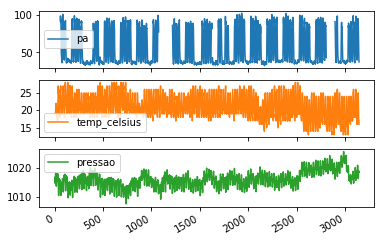

In [4]:
raw.plot(subplots=True)

Text(0.5, 0, 'Potência Ativa (KW)')

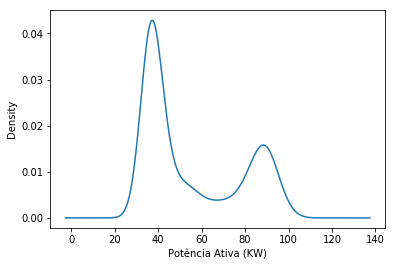

In [5]:
raw['pa'].plot.kde().set_xlabel("Potência Ativa (KW)")

Text(0.5, 0, 'temperatura (ºC)')

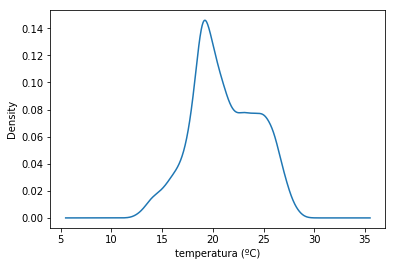

In [6]:
raw['temp_celsius'].plot.kde().set_xlabel("temperatura (ºC)")

Text(0.5, 0, 'Pressão (hPa)')

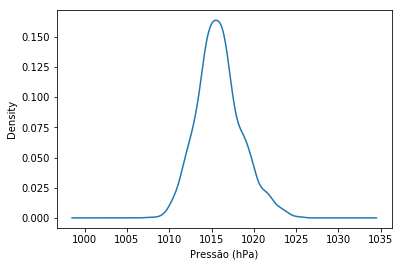

In [7]:
raw['pressao'].plot.kde().set_xlabel("Pressão (hPa)")

# Data cleaning
* Filtra horários de aula
* remover linhas incompletas (sistema fora do ar)
* remover oulier (falhas na coleta de dados).
* remover dias não-letivos
* remover dias com falhas na medição (sistema fora do ar)

In [8]:
processed = raw.dropna()
processed = processed.set_index(pd.to_datetime (processed['momento'])).drop('momento', axis=1)

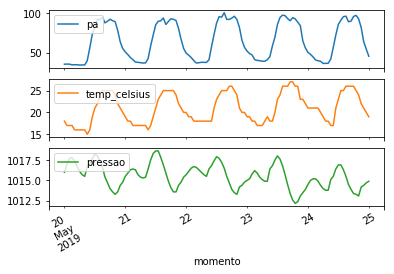

In [9]:

(ax1, ax2, ax3) = processed['2019-05-20 00:00:00' : '2019-05-25 00:00:00'].plot(subplots=True, sharex=True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

In [10]:
## Remove fins de semana
# Create an index of just the date portion of your index (this is the slow step)
dfDays = pd.to_datetime(processed.index.date)

# Create a range of business days over that period
dfBdays = pd.bdate_range(start=processed.index[0].date(), end=processed.index[-1].date())

#Filter the series to just those days contained in the business day range.
filtered = processed[dfDays.isin(dfBdays)]

In [11]:
## Removendo dias não-letivos ou com erros
# março
# abril 19, 25, 26
# maio 1, 9, 10
# junho 20
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 19))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 25))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 26))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 1))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 9))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 10))]
filtered = filtered[~((filtered.index.month == 6) & (filtered.index.day == 20))]

In [12]:
# Selecionando horários de aula
filtered1 = filtered.between_time('08:00:00', '11:00:00')
filtered2 = filtered.between_time('14:00:00', '17:00:00')
filtered = pd.concat([filtered1, filtered2])

In [13]:
filtered = filtered[~((filtered['pa']<50) & (filtered['temp_celsius']>22))]

Text(0, 0.5, 'Potência ativa (KW)')

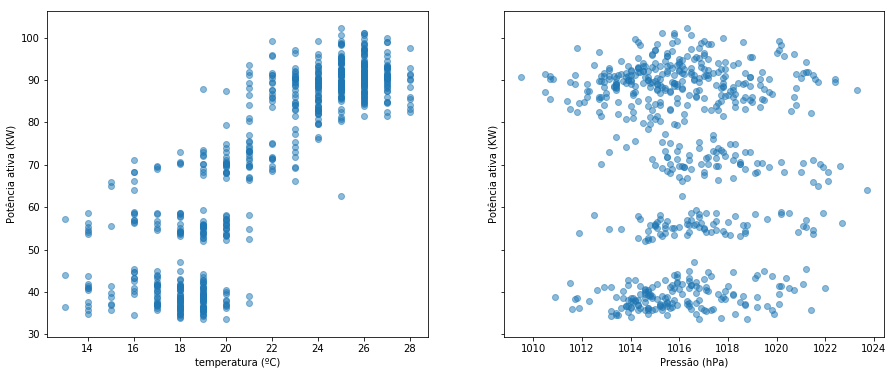

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,6))
ax1.scatter(filtered['temp_celsius'], filtered['pa'], Alpha=0.5)
ax1.set_xlabel("temperatura (ºC)")
ax1.set_ylabel("Potência ativa (KW)")
ax2.scatter(filtered['pressao'], filtered['pa'], Alpha=0.5)
ax2.set_xlabel("Pressão (hPa)")
ax2.set_ylabel("Potência ativa (KW)")

In [15]:
filtered.describe()

,pa,temp_celsius,pressao
count,626.000000,626.000000,626.000000
mean,69.914024,21.638978,1016.243131
std,22.070516,3.755829,2.465920
min,33.628650,13.000000,1009.500000
25%,44.038273,19.000000,1014.600000
50%,75.067213,21.500000,1015.950000
75%,89.782868,25.000000,1017.700000
max,102.172806,28.000000,1023.700000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f60c8d17d68>,
      dtype=object)

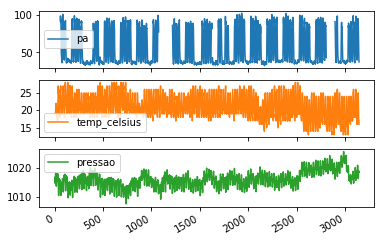

In [16]:
raw.plot(subplots=True)

In [17]:
# Cross validation split
from sklearn.model_selection import train_test_split 
X = filtered.drop('pa', axis=1)
y = filtered ['pa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 

# Linear Regression

In [18]:
model1 = LinearRegression()
model1.fit (X_train, y_train)
pd.DataFrame(model1.coef_,X.columns,columns=['Coefficient'])

,Coefficient
temp_celsius,5.903892
pressao,3.376242


MAE:                 7.738410570428554
RMSE:                9.854911400433773
Percentual:          10.911722498011715 %


Text(0, 0.5, 'Valores previstos')

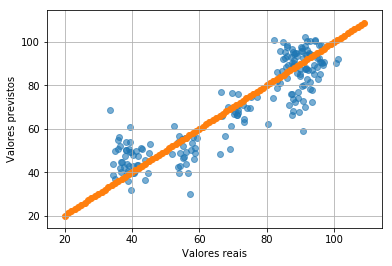

In [28]:
from sklearn import metrics
y_hat1 = model1.predict(X_test)

print ("MAE:                ", metrics.mean_absolute_error(y_test, y_hat1))
print ("RMSE:               ", np.sqrt(metrics.mean_squared_error(y_test, y_hat1)))
print ("Percentual:         ", metrics.mean_absolute_error(y_test,y_hat1)/y_test.mean()*100, "%")

# Previsto vs real
line = np.arange(20, 110, 1)

plt.scatter(y_test,y_hat1, Alpha=0.6)
plt.scatter(line,line)
plt.grid(True)
plt.xlabel("Valores reais")
plt.ylabel("Valores previstos")

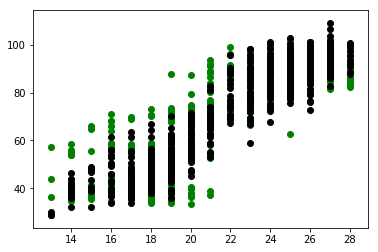

In [20]:
plt.scatter(X['temp_celsius'], y,color='g')
plt.scatter(X['temp_celsius'], model1.predict(X),color='k')

plt.show()

# Random Forest

In [21]:
import sklearn.metrics as metrics
import math
from sklearn.ensemble import RandomForestRegressor

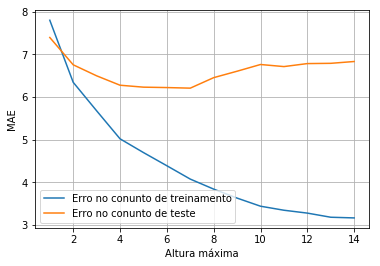

In [22]:
mae1 = {}
mae2 = {}
for k in range(1,15, 1):
    model2 = RandomForestRegressor(max_depth=k, n_estimators=100, criterion='mae').fit(X_train,y_train)
    y_hat = model2.predict(X_train)
    mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
    y_hat = model2.predict(X_test)
    mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

plt.figure()
plt.plot(list(mae1.keys()), list(mae1.values()), label='Erro no conunto de treinamento')
plt.plot(list(mae2.keys()), list(mae2.values()), label='Erro no conunto de teste')
plt.legend(loc='lower left')
plt.xlabel("Altura máxima")
plt.ylabel("MAE")
plt.grid(True)

In [23]:
# Random Forest
model2 = RandomForestRegressor(max_depth=5, n_estimators=100)
model2.fit(X_train,y_train)

# Model Evaluation
y_hat2 = model2.predict(X_test)

print ("MAE:                ", metrics.mean_absolute_error(y_test,y_hat2))
print ("RMSE:               ", math.sqrt(metrics.mean_squared_error(y_test,y_hat2)))
print ("Percentual:         ", metrics.mean_absolute_error(y_test,y_hat2)/y_test.mean()*100, "%")

# Feature analysis
print ("=====================================")
print ("FEATURE IMPORTANCE:")
for i in range(model2.feature_importances_.size):
    print (X_train.columns[i], "=", model2.feature_importances_[i])

MAE:                 6.175705373509917
RMSE:                8.659710019327848
Percentual:          8.708194357473602 %
FEATURE IMPORTANCE:
temp_celsius = 0.9125899908353421
pressao = 0.08741000916465773


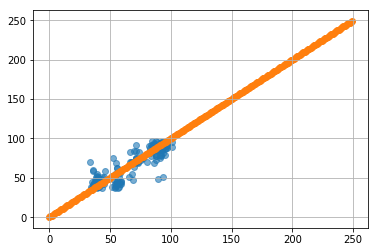

In [24]:
# Previsto vs real
line = np.arange(0, 250, 1)

plt.scatter(y_test,y_hat, Alpha=0.6)
plt.scatter(line,line)
plt.grid(True)

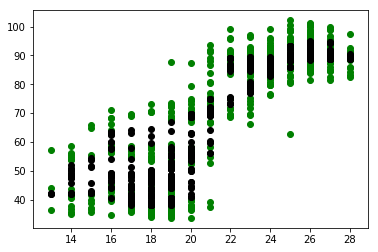

In [25]:
plt.scatter(X['temp_celsius'], y,color='g')
plt.scatter(X['temp_celsius'], model2.predict(X),color='k')

plt.show()